# Importaciones

In [29]:
# Funciones y módulos para modelos supervisados de regresión
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
# Funciones y módulos para análisis de datos y evaluación de modelos
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
# Funciones y módulos para modelos de aprendizaje profundo
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor
# Funciones y módulos para modelos de series temporales
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
# Funciones y módulos para preparación y visualización de datos
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Descarga

In [30]:
# Definición de datos
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']
#Descarga de datos
stk_data = yf.download(stk_tickers)['Adj Close'].dropna()
stk_data.columns.name = ''
stk_data.index.name = 'DATE'
ccy_data = pdr.get_data_fred(ccy_tickers, start=stk_data.index[0]).dropna()
idx_data = pdr.get_data_fred(idx_tickers, start=stk_data.index[0]).dropna()

[*********************100%%**********************]  3 of 3 completed


# Procesamiento

In [31]:
# Retorno en los 5 días de la semana
return_period = 5
# Defino la variable dependiente como lag de 5 días
Y = (np.log(stk_data.loc[:, 'MSFT'])
     .diff(return_period)
     .shift(-return_period)
)
Y.name = Y.name + '_pred'
# Se definen las variables independientes
X1 = np.log(stk_data.loc[: , ('GOOGL', 'IBM')]).diff(return_period)
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = (
     pd.concat([np.log(stk_data.loc[:, 'MSFT']).diff(i)
     for i in [return_period, return_period*3,
     return_period*6, return_period*12]], axis=1)
     .dropna()
)
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']
X = pd.concat([X1, X2, X3, X4], axis=1)
dataset = pd.concat([X, Y], axis=1, join='inner').dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

# Visualización

<Axes: title={'center': 'Matriz de correlación'}>

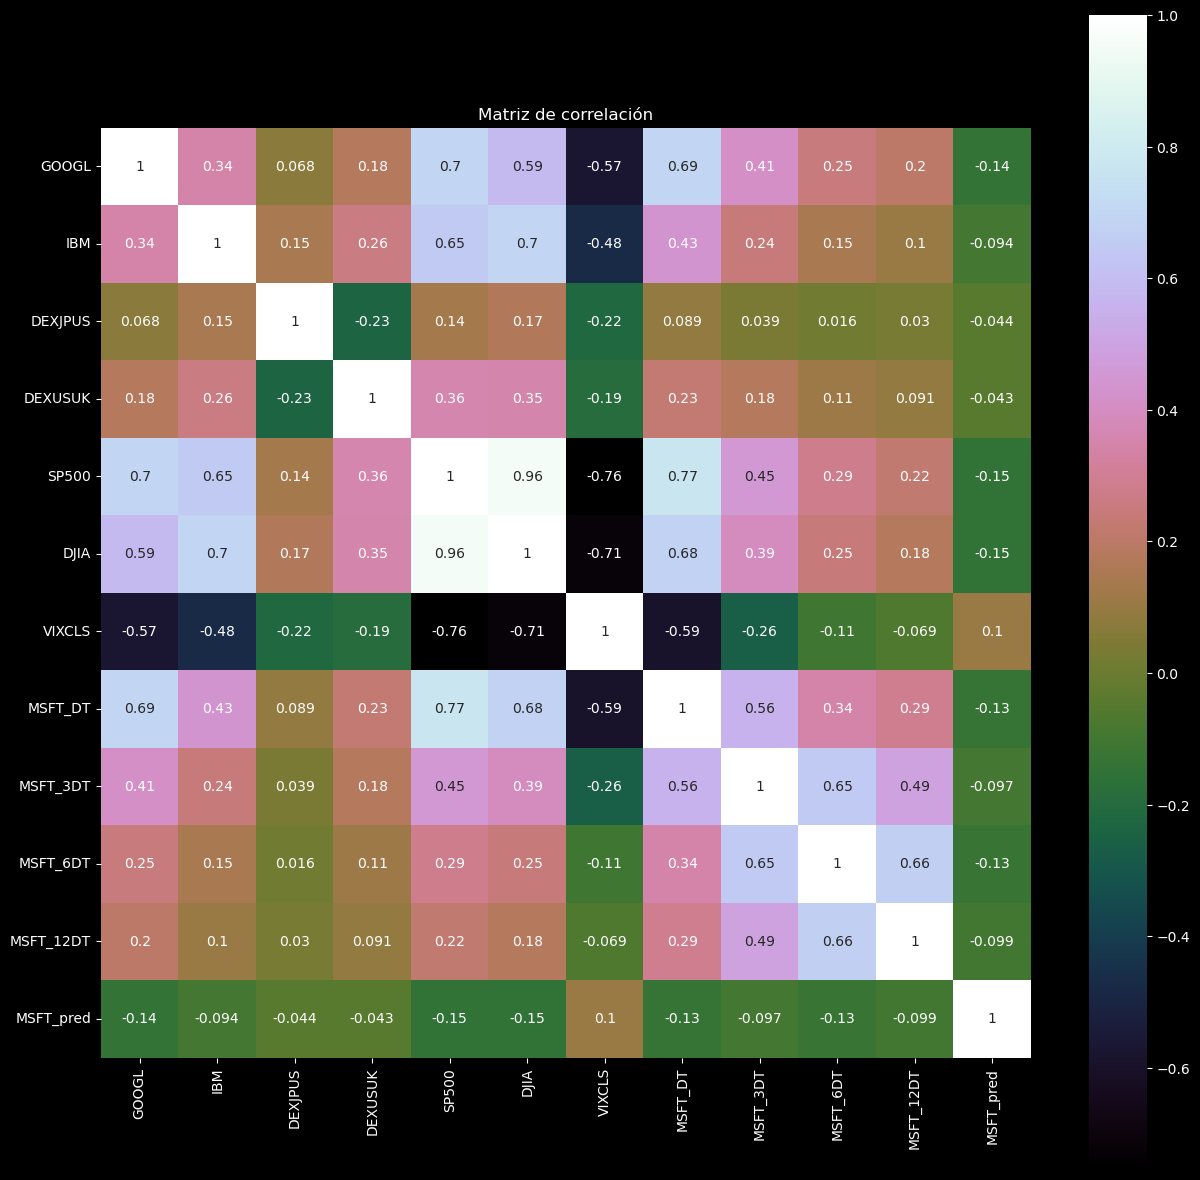

In [32]:
correlation = dataset.corr()
pyplot.figure(figsize=(15, 15))
pyplot.title('Matriz de correlación')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

<Figure size 1500x1500 with 0 Axes>

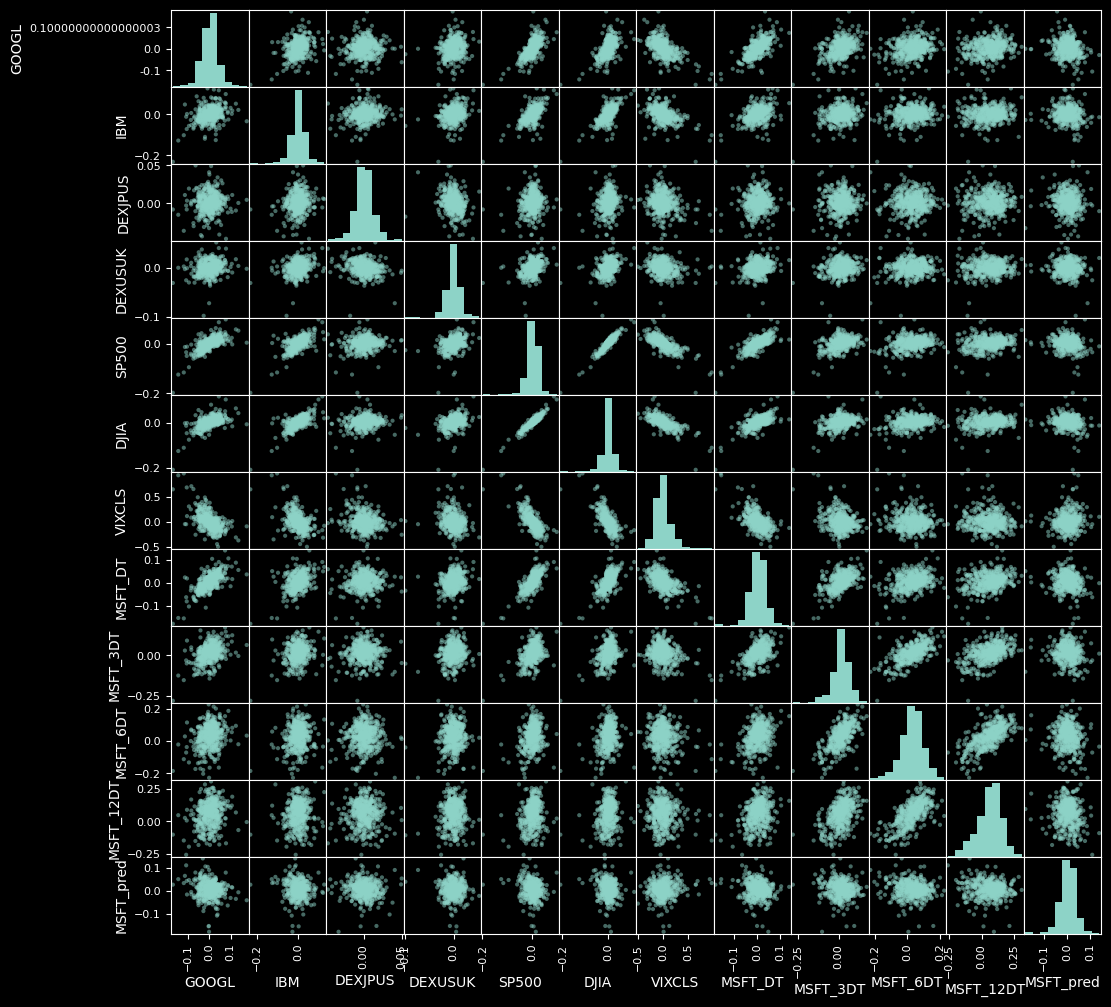

In [33]:
pyplot.figure(figsize=(15, 15))
scatter_matrix(dataset, figsize=(12, 12))
pyplot.show()

# Análisis de la serie temporal

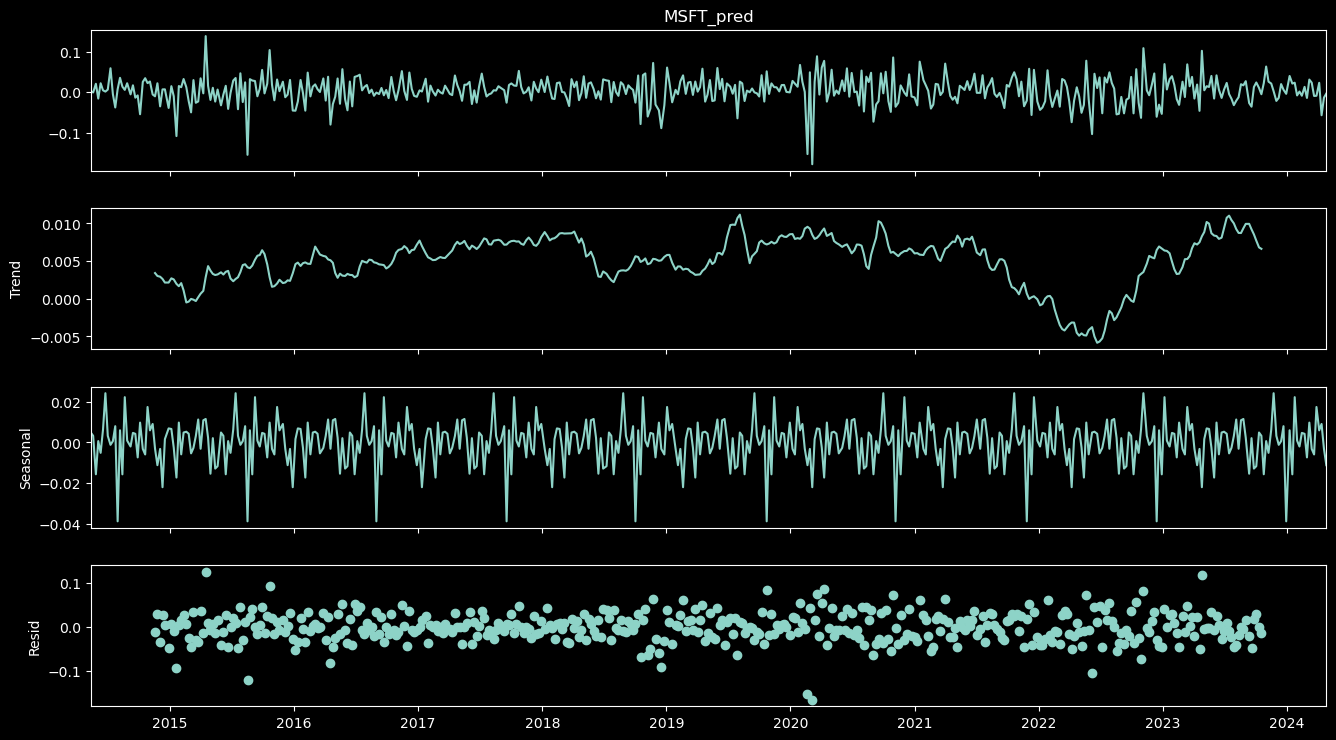

In [34]:
res = sm.tsa.seasonal_decompose(Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

# Evaluación de modelos

In [35]:
# Train test split
validation_size = 0.2
train_size = int(len(X) * (1 - validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [36]:
# Optimización de hiperparámetros
num_folds = 10
scoring = 'neg_mean_squared_error'

In [37]:
models = []
# Algoritmos de regresión
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
# Redes neuronales
models.append(('MLP', MLPRegressor()))
# Modelos ensamblados
## Modelos Boosting
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
## Modelos Bagging
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [38]:
# Entrenamiento y validación
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    ## Análisis k-fold
    kfold = KFold(n_splits=num_folds, shuffle=False)
    ## convertir el error cuadrático medio a positivo, siendo el menor el mejor
    cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    # Entrenamiento del período completo
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    # Resultados en test
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    

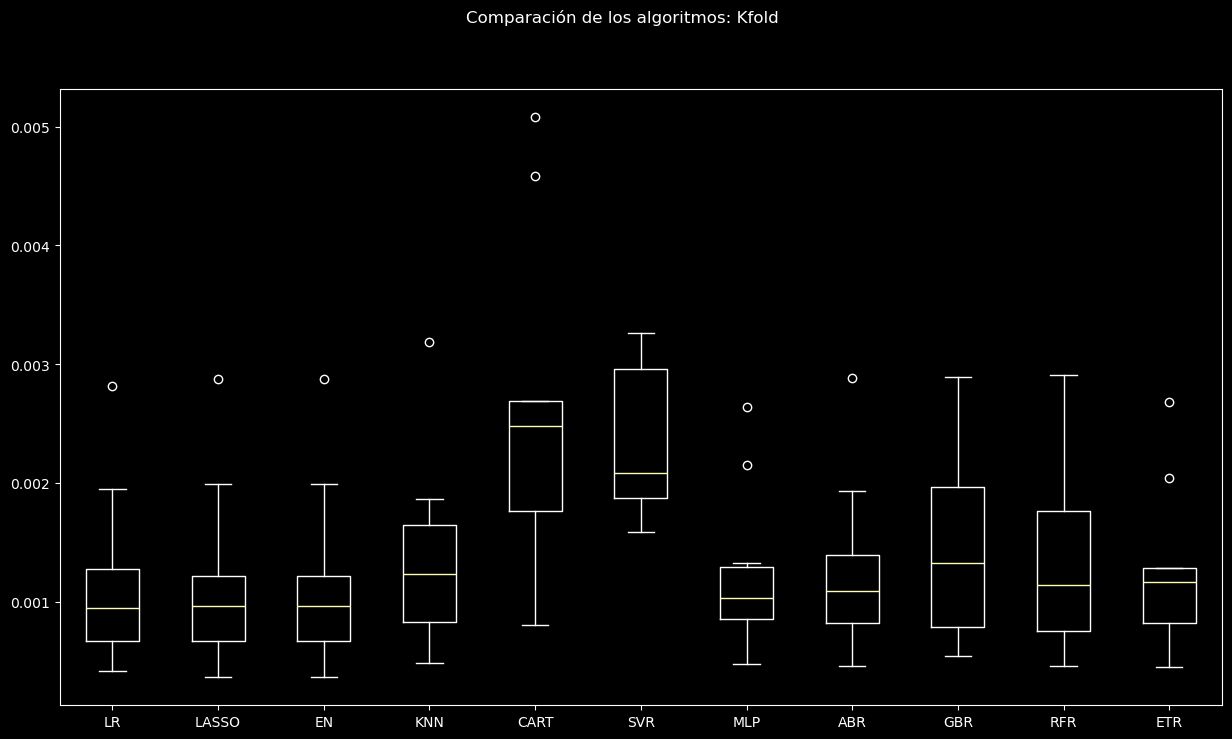

In [39]:
# Visualización de los resultados de la validación cruzada
fig = pyplot.figure()
fig.suptitle('Comparación de los algoritmos: Kfold')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
pyplot.show()

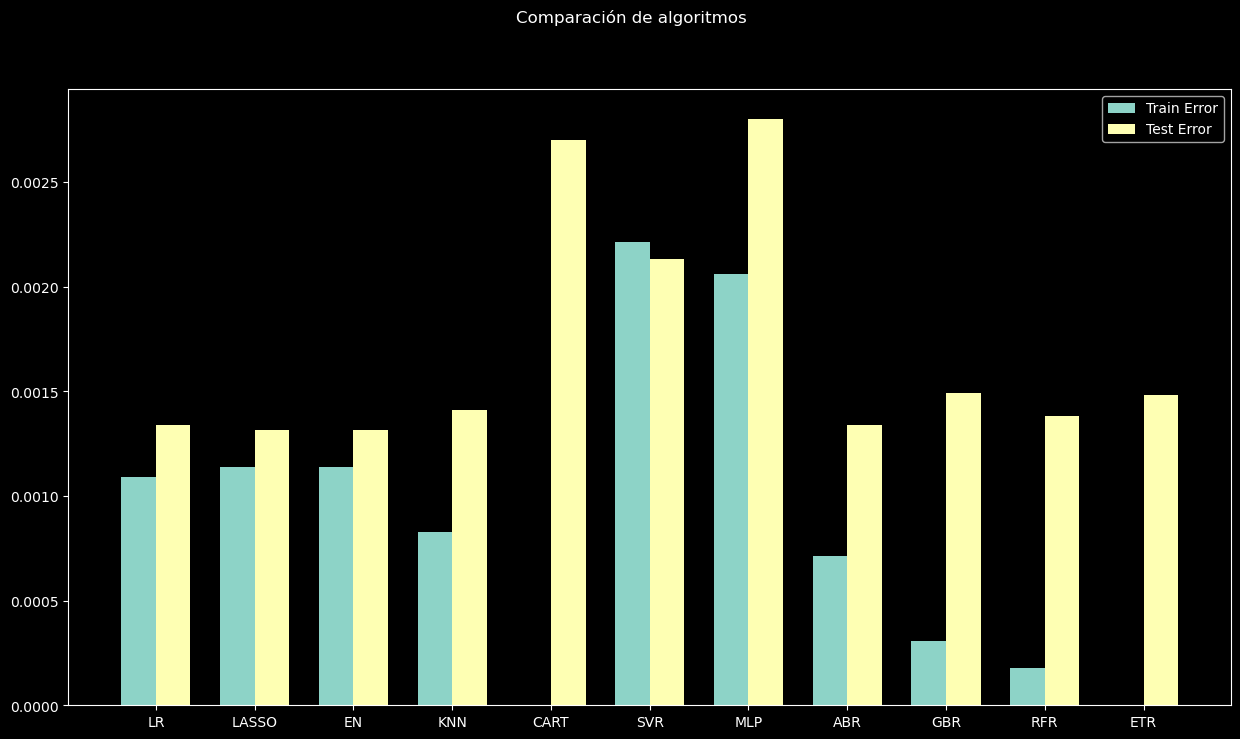

In [40]:
def comparative_display(train_results, test_results, names):
    # Visualización comparativa entre train y test
    fig = pyplot.figure()
    ind = np.arange(len(names))
    width = 0.35
    fig.suptitle('Comparación de algoritmos')
    ax = fig.add_subplot(111)
    pyplot.bar(ind - width/2, train_results, width=width, label='Train Error')
    pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
    fig.set_size_inches(15, 8)
    pyplot.legend()
    ax.set_xticks(ind)
    ax.set_xticklabels(names)
    pyplot.show()
comparative_display(train_results, test_results, names)

# Modelos basados en series temporales: ARIMA y LSTM

In [41]:
# Se usan los activos correlacionados como variables exógenas
X_train_ARIMA = X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA = X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len(X)
# Creación y entrenamiento del modelo ARIMA
model_ARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[1, 0, 0])
model_fit = model_ARIMA.fit()
# Se calcula el error del modelo
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start=tr_len-1, end=to_len-1, exog=X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test, predicted)
error_Test_ARIMA

0.0013010086906030738

In [42]:
# Longitud de la secuencia LSTM
seq_len = 2
# Aquí se crea dos arrays tridimensionales en el que cada registro muestral
# consta a su vez de dos registros y cada uno de los cuales contiene 11 características
Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0] + 1 - seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0] + i + 1 - seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0] + i - 1:X.shape[0] + i + 1 - seq_len, :]

In [43]:
# Red LSTM
def create_LSTM_model(learn_rate = 0.01, momentum=0):
    # creación del modelo
    model = Sequential()
    model.add(
        LSTM(
            50,
            input_shape=(X_train_LSTM.shape[1],
            X_train_LSTM.shape[2])
        )
    )
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTM_model = create_LSTM_model(learn_rate=0.01, momentum=0)
LSTM_model_fit = LSTM_model.fit(X_train_LSTM,
                                Y_train_LSTM,
                                validation_data=(X_test_LSTM,
                                                 Y_test_LSTM),
                                epochs=330,
                                batch_size=72,
                                verbose=0,
                                shuffle=False)

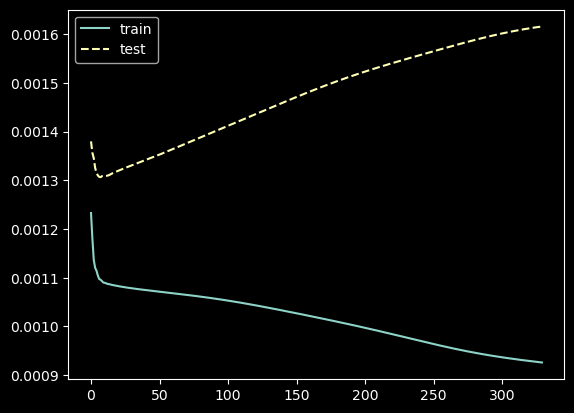

In [44]:
# Visualizar rendimiento de la red LSTM
pyplot.plot(LSTM_model_fit.history['loss'], label='train')
pyplot.plot(LSTM_model_fit.history['val_loss'], '--', label='test')
pyplot.legend()
pyplot.show()

In [45]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM,
                                         LSTM_model.predict(X_train_LSTM))
predicted = LSTM_model.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test, predicted)

4/4 [==============================] - 0s 3ms/step


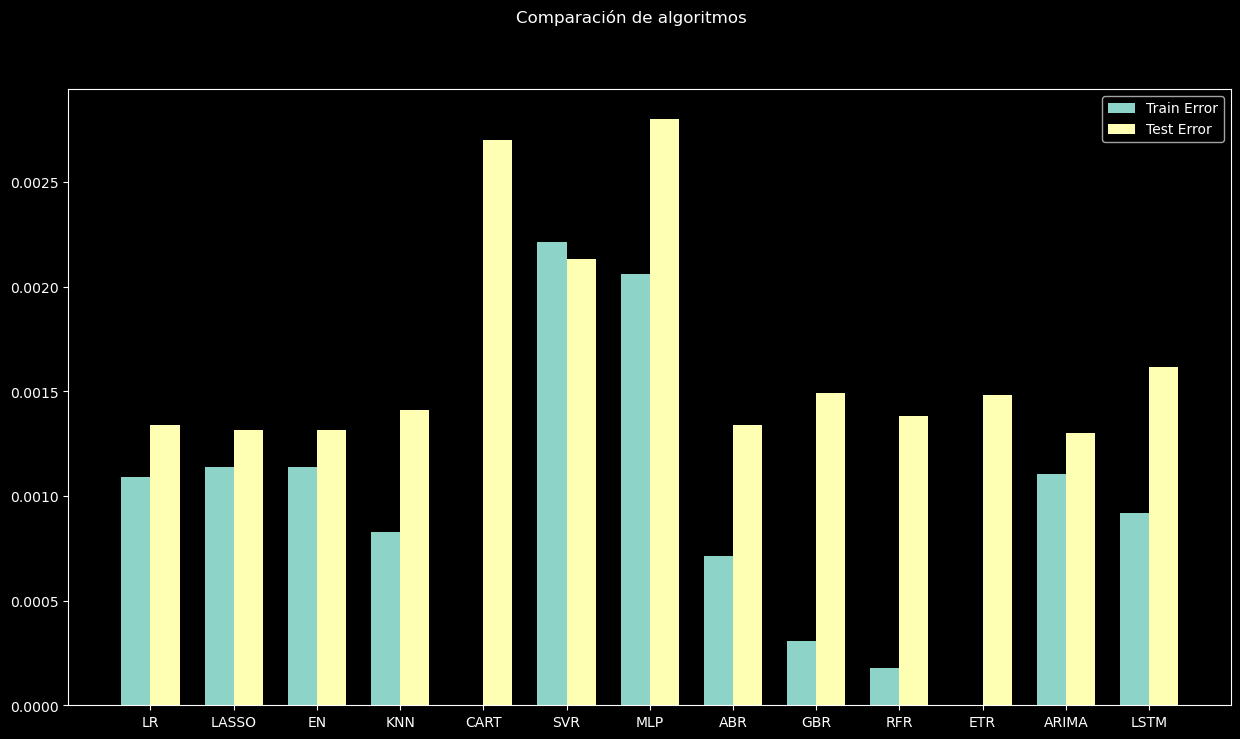

In [46]:
# Agrego los resultados de los modelos para comparar con los anteriores
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)
train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)
names.append('ARIMA')
names.append("LSTM")
comparative_display(train_results, test_results, names)

## Tuning del modelo ARIMA

In [47]:
def evaluate_arima_model(arima_order):
    model_ARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=arima_order)
    model_fit = model_ARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
def evaluate_models(p_values, d_values, q_values):
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_arima_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print(f'ARIMA{order} MSE={mse}')
                except:
                    continue
    print(f'Best ARIMA{best_cfg} MSE={best_score}')
    return best_cfg

In [48]:
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
best_cfg = evaluate_models(p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.0011080760070043708
ARIMA(0, 0, 1) MSE=0.0011071345510216164
ARIMA(0, 1, 0) MSE=0.0019493638121742024
ARIMA(0, 1, 1) MSE=0.0011210933144244388
ARIMA(1, 0, 0) MSE=0.0011072939438816168
ARIMA(1, 0, 1) MSE=0.0010909794322687641
ARIMA(1, 1, 0) MSE=0.0016790478474642903
ARIMA(1, 1, 1) MSE=0.001140540455135341
ARIMA(2, 0, 0) MSE=0.001106296650336355
ARIMA(2, 0, 1) MSE=0.0011002695130416765
ARIMA(2, 1, 0) MSE=0.0014915768775467452
ARIMA(2, 1, 1) MSE=0.0011639835946514127
Best ARIMA(1, 0, 1) MSE=0.0010909794322687641


In [49]:
model_ARIMA_tuned = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=best_cfg)
model_fit_tuned = model_ARIMA_tuned.fit()
predicted_tuned = model_fit_tuned.predict(start=tr_len - 1,
                                            end=to_len - 1,
                                            exog=X_test_ARIMA)[1:]
print(mean_squared_error(Y_test, predicted_tuned))

0.0013219755290995758


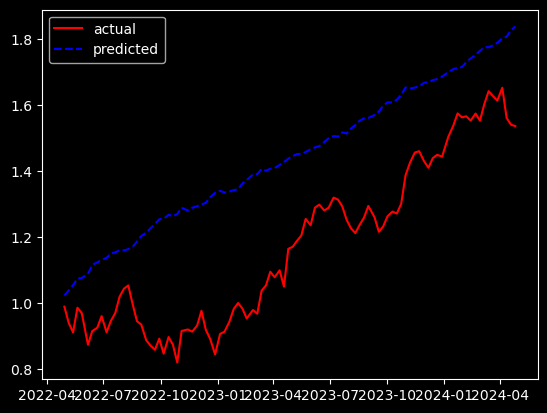

In [55]:
predicted_tuned.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r', label='actual')
pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b--', label='predicted')
pyplot.legend()
pyplot.rcParams['figure.figsize']=(8, 5)
pyplot.show()